#####Background: The dataset is obtained from Kaggle from 2 day credit card transactions by European cardholder in 2013. Variables V1-V28 are the result of the Principle Component Analysis (PCA) while Time and Amount are the original variables. There are 29 variable columns and 1 Class column. 
#####Aim: To identify fraud credit card transaction so that customers will not be charged for items that they did not purchase. 
#####Problem: Data is highly imbalanced, number of genuine transactions are more than fraud transactions.
#####Dataset: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download



##Importing library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

##Loading data

In [2]:
cc = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Portfolio/CC_Classification/creditcarddata.csv")

##Data Understanding & Cleaning

In [3]:
#Listing the first 5 rows of the dataset
cc.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
#Number of columns and rows of the dataset
cc.shape

(284807, 31)

In [5]:
#Number of transaction by Class type
print(cc["Class"].value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [6]:
print((cc["Class"].value_counts()/len(cc)*100))

0    99.827251
1     0.172749
Name: Class, dtype: float64


In [7]:
#Basic summary of the dataset
print("Total number of credit card transaction recorded:{} \n".format(cc.shape[0]), "Total number of genuine transaction: {} \n".format(284315), 
      "Total number of genuine transaction: {} \n".format(492), "Percentage of fraud transaction: {} \n".format(0.17))

Total number of credit card transaction recorded:284807 
 Total number of genuine transaction: 284315 
 Total number of genuine transaction: 492 
 Percentage of fraud transaction: 0.17 



In [8]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

#####There is no missing value.

Distribution of Class variable


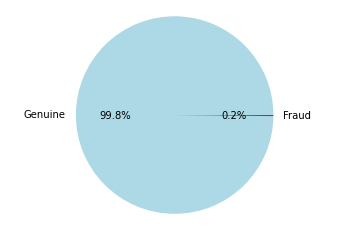

In [9]:
#View on Class column, 0 is genuine transaction while 1 is fraud transaction
fig, ax = plt.subplots(1, 1)
ax.pie(cc.Class.value_counts(), autopct="%1.1f%%", labels=["Genuine", "Fraud"], colors=["lightblue", "red"])
plt.axis("equal")
plt.ylabel("")

print("Distribution of Class variable")

#####Genuine credit card transaction is more than Fraud credit card transaction. This shows that the dataset is highly imbalanced. However, this is normal situation nowsaday as banks has strong security system yet there is some vulnerablity in their system.

284802    47.996111
284803    47.996389
284804    47.996667
284805    47.996667
284806    47.997778
Name: Time_Hr, dtype: float64
Time variable


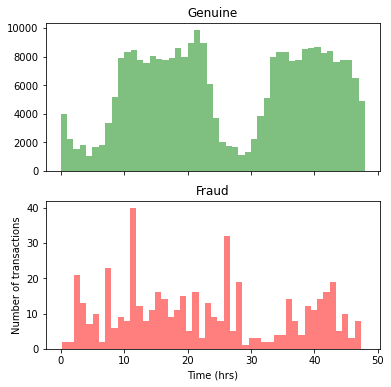

In [10]:
#Visual any trend based on time
cc["Time_Hr"] = cc["Time"]/3600 # convert to hours
print(cc["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,6))
ax1.hist(cc.Time_Hr[cc.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(cc.Time_Hr[cc.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('Number of transactions')

print("Time variable")

#####The Time variable shows almost similar pattern against the number of transaction for both Genuine and Fraus transactions. Thus, this variable might not yield any predictive power to distinguish between the two classes. For now, I will only keep Time_Hr and drop Time.

In [11]:
#Drop Time variable from the original dataset

cc = cc.drop(["Time"], axis=1)
cc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Time_Hr
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000278
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000278
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000556


Text(0, 0.5, 'Number of transactions')

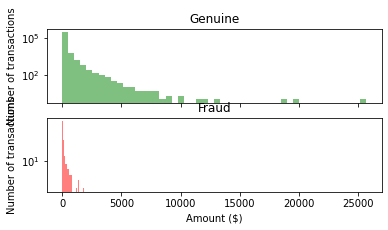

In [12]:
#Check on Amount variable
fig, (ax3,ax4) = plt.subplots(2,1, figsize = (6,3), sharex = True)
ax3.hist(cc.Amount[cc.Class==0],bins=50,color='g',alpha=0.5)
ax3.set_yscale('log') # to see the tails
ax3.set_title('Genuine') # to see the tails
ax3.set_ylabel('Number of transactions')
ax4.hist(cc.Amount[cc.Class==1],bins=50,color='r',alpha=0.5)
ax4.set_yscale('log') # to see the tails
ax4.set_title('Fraud') # to see the tails
ax4.set_xlabel('Amount ($)')
ax4.set_ylabel('Number of transactions')

In [13]:
min(cc.Amount), max(cc.Amount)

(0.0, 25691.16)

#####Majority of the fraud transactions is less than $10,000. The Amount variable has a huge difference thus standadization will be carried out later.

In [14]:
#from sklearn.preprocessing import StandardScaler
#cc['scaled_Amount'] = StandardScaler().fit_transform(cc["Amount"].values.reshape(-1,1))  #-1 in reshape function is used when you dont know or want to explicitly tell the dimension of that axis.
#cc =cc.drop(['Amount'],axis=1)
#cc.head()

In [15]:
#min(cc.scaled_Amount), max(cc.scaled_Amount)

In [16]:
#Check on Amount variable after standardization 
#fig, (ax5,ax6) = plt.subplots(2,1, figsize = (6,3), sharex = True)
#ax5.hist(cc.scaled_Amount[cc.Class==0],bins=50,color='g',alpha=0.5)
#ax5.set_yscale('log') # to see the tails
#ax5.set_title('Genuine') # to see the tails
#ax5.set_ylabel('Number of transactions')
#ax6.hist(cc.scaled_Amount[cc.Class==1],bins=50,color='r',alpha=0.5)
#ax6.set_yscale('log') # to see the tails
#ax6.set_title('Fraud') # to see the tails
#ax6.set_xlabel('Amount ($)')
#ax6.set_ylabel('Number of transactions')

#####Standardization library has tried it best to transform data to fit normal distribution without changing the data. 

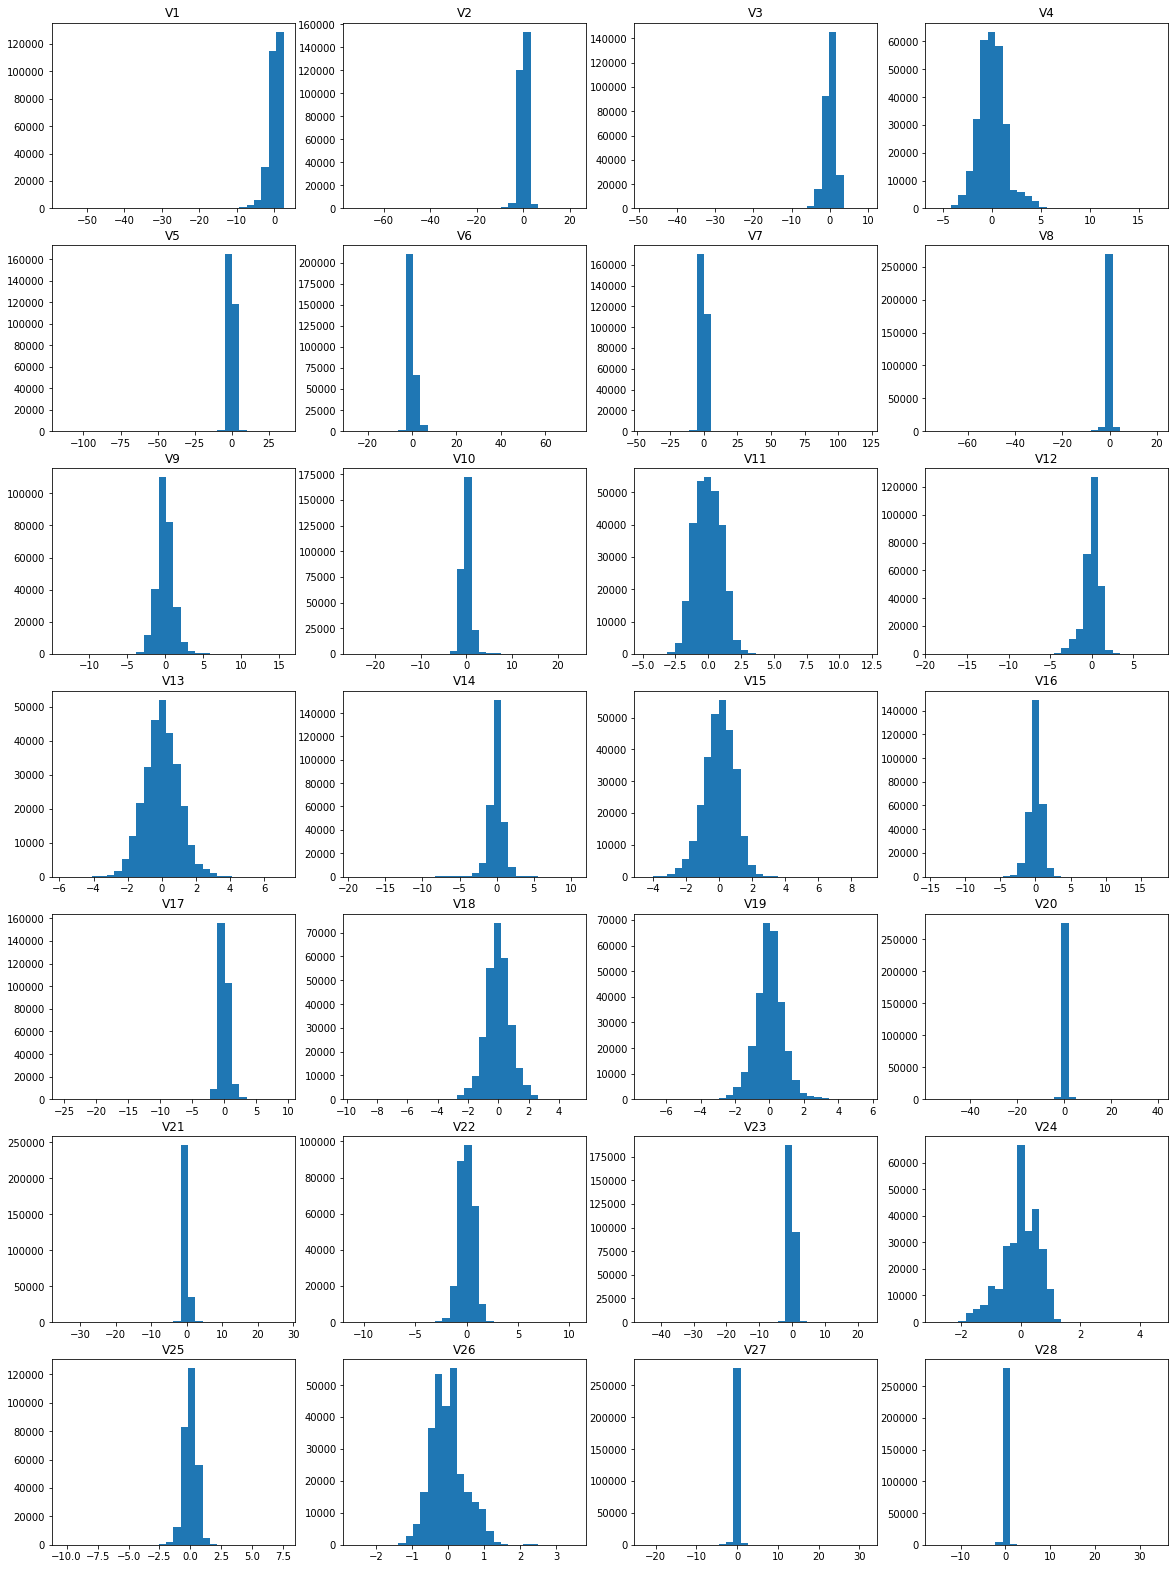

In [17]:
#Check the distribution for the 28 PCA variables

n_cols = 4
n_rows = 7

num_variable = [col for col in cc.columns if col.find('V') > -1]

fig = plt.gcf()
fig.set_size_inches(n_cols * 5, n_rows * 4)

for pos, var in enumerate(num_variable):
    sp = plt.subplot(n_rows, n_cols, pos + 1)
    plt.hist(cc[var], bins=30)
    plt.title(var)

plt.show()

#####Most of the variables are having normal distribution.

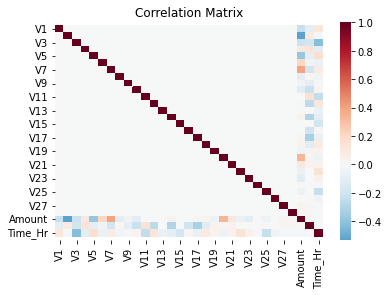

In [18]:
#Check the correlation of all the variables
correlation = cc.corr()
ax = sns.heatmap(correlation, center=0, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()

#####All the variables have weak correlation to each other.

In [19]:
#Check any duplicate transaction
print(cc[cc.duplicated()])

              V1        V2        V3        V4        V5        V6        V7  \
33     -0.529912  0.873892  1.347247  0.145457  0.414209  0.100223  0.711206   
35     -0.535388  0.865268  1.351076  0.147575  0.433680  0.086983  0.693039   
113     1.038370  0.127486  0.184456  1.109950  0.441699  0.945283 -0.036715   
114     1.038370  0.127486  0.184456  1.109950  0.441699  0.945283 -0.036715   
115     1.038370  0.127486  0.184456  1.109950  0.441699  0.945283 -0.036715   
...          ...       ...       ...       ...       ...       ...       ...   
282987  1.912550 -0.455240 -1.750654  0.454324  2.089130  4.160019 -0.881302   
283483 -1.464380  1.368119  0.815992 -0.601282 -0.689115 -0.487154 -0.303778   
283485 -1.457978  1.378203  0.811515 -0.603760 -0.711883 -0.471672 -0.282535   
284191 -2.667936  3.160505 -3.355984  1.007845 -0.377397 -0.109730 -0.667233   
284193 -2.691642  3.123168 -3.339407  1.017018 -0.293095 -0.167054 -0.745886   

              V8        V9       V10  .

In [20]:
#Remove duplicate transaction
cc.drop_duplicates(inplace=True)
cc.shape

(283726, 31)

#####We have removed 1081 row of duplicated transactions. The total transactions reduced from 284807 to 283726. 

##Model Building

In [21]:
#Define independent, X, and dependent variables, y.
X = cc.drop("Class", axis=1).values
y = cc["Class"].values

In [22]:
#Treat Imbalance data using Synthetic Minority Over-sampling Technique (SMOTE)
sm = SMOTE(random_state=42)
#X_res, y_res = sm.fit_resample(X_train, y_train)
X_bal, y_bal = sm.fit_resample(X, y)

In [23]:
#unique_elements, counts_elements = np.unique(y, return_counts=True)
#print("Frequency of unique values Class before SMOTE:")
#print(np.asarray((unique_elements, counts_elements)))

#unique_elements, counts_elements = np.unique(y_bal, return_counts=True)
#print("Frequency of unique values Class after SMOTE:")
#print(np.asarray((unique_elements, counts_elements)))

In [54]:
def print_unique(label_before, label_after):
  unielementbefore, countelementbefore = np.unique(label_before, return_counts=True)
  print("Frequency of unique values Class before SMOTE: Geinue is {ybefore0}, while fraud is {ybefore1}".format(ybefore0=countelementbefore[0], ybefore1=countelementbefore[1]))
  
  unielementafter, countelementafter = np.unique(label_after, return_counts=True)
  print("Frequency of unique values Class after SMOTE: Geinue is {yafter0}, while fraud is {yafter1}".format(yafter0=countelementafter[0], yafter1=countelementafter[1]))
  print("An increased of ", countelementafter[1]-countelementbefore[1], "to achieve balancing") 

In [55]:
print_unique(y, y_bal)

Frequency of unique values Class before SMOTE: Geinue is 283253, while fraud is 473
Frequency of unique values Class after SMOTE: Geinue is 283253, while fraud is 283253
An increased of  282780 to achieve balancing


In [26]:
#Spliting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.30, random_state=1)

In [27]:
#Classification model 1 - Decision Tree
#from sklearn.tree import DecisionTreeClassifier 
#DT = DecisionTreeClassifier(max_depth=4, criterion='entropy')
#DT.fit(X_train, y_train)
#DT.pred = DT.predict(X_test)

In [28]:
#Initiate model pipeline
dt_pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier())
xgb_pipe = make_pipeline(StandardScaler(), XGBClassifier())
lgbm_pipe = make_pipeline(StandardScaler(), LGBMClassifier())

In [29]:
#Check the parameters availale
#xgb_pipe.get_params()

In [30]:
#Create search grid
param_grid_dt = {"decisiontreeclassifier__max_depth": [2, 4], "decisiontreeclassifier__min_samples_split" : [5, 10]}
param_grid_xgb = {"xgbclassifier__max_depth": [2, 4], "xgbclassifier__learning_rate": [0.01, 0.2], "xgbclassifier__min_child_weight": [1, 4]}
param_grid_lgbm = {"lgbmclassifier__max_depth": [2, 4], "lgbmclassifier__learning_rate": [0.01, 0.2], "lgbmclassifier__n_estimators": [5,10]}

In [31]:
#Initiate grid search
dt_grid = GridSearchCV(dt_pipe, param_grid_dt, cv=5)
xgb_grid = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5)
lgbm_grid = GridSearchCV(lgbm_pipe, param_grid_lgbm , cv=5)

In [32]:
#Run grid search
dt_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
lgbm_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lgbmclassifier', LGBMClassifier())]),
             param_grid={'lgbmclassifier__learning_rate': [0.01, 0.2],
                         'lgbmclassifier__max_depth': [2, 4],
                         'lgbmclassifier__n_estimators': [5, 10]})

In [33]:
#Report best parameter & score
print(dt_grid.best_params_)
print(dt_grid.score(X_test, y_test))

print(xgb_grid.best_params_)
print(xgb_grid.score(X_test, y_test))

print(lgbm_grid.best_params_)
print(lgbm_grid.score(X_test, y_test))

{'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_split': 10}
0.9520276313311994
{'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 1}
0.9984054321220109
{'lgbmclassifier__learning_rate': 0.2, 'lgbmclassifier__max_depth': 4, 'lgbmclassifier__n_estimators': 10}
0.9658256448879684


In [36]:
#Output the prediction result using the model with the best predictive model
#dt_pred = dt_grid.predict(X_test)
#dt_pred = dt_pipe.predict(X_test)
#print(dt_pred)

#xgb_pred = xgb_grid.predict(X_test)
xgb_pred = xgb_grid.predict(X_test)
#xgb_pred = xgb_pipe.predict(X_test)
print(xgb_pred)

#lgbm_pred = lgbm_grid.predict(X_test)
#print(lgbm_pred)

[0 1 1 ... 1 0 1]


In [37]:
#Get importance
#importance = cc.feature_importances_

AttributeError: ignored

In [53]:
#display(X)

array([[-1.35980713e+00, -7.27811733e-02,  2.53634674e+00, ...,
        -2.10530535e-02,  1.49620000e+02,  0.00000000e+00],
       [ 1.19185711e+00,  2.66150712e-01,  1.66480113e-01, ...,
         1.47241692e-02,  2.69000000e+00,  0.00000000e+00],
       [-1.35835406e+00, -1.34016307e+00,  1.77320934e+00, ...,
        -5.97518406e-02,  3.78660000e+02,  2.77777778e-04],
       ...,
       [ 1.91956501e+00, -3.01253846e-01, -3.24963981e+00, ...,
        -2.65608286e-02,  6.78800000e+01,  4.79966667e+01],
       [-2.40440050e-01,  5.30482513e-01,  7.02510230e-01, ...,
         1.04532821e-01,  1.00000000e+01,  4.79966667e+01],
       [-5.33412522e-01, -1.89733337e-01,  7.03337367e-01, ...,
         1.36489143e-02,  2.17000000e+02,  4.79977778e+01]])

In [41]:
#Define independent, XX, and dependent variables, yy.
XX = cc.drop("Class", axis=1)
yy = cc["Class"]

In [46]:
#print(xgb_grid.best_estimator_)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(learning_rate=0.2, max_depth=4))])


In [48]:
#Define the best estimator from param
xgb_bestestimators = XGBClassifier(xgbclassifier__learning_rate= 0.2, xgbclassifier__max_depth = 4, xgbclassifier__min_child_weight = 1)

In [50]:
#Fit the best estimator to the model
xgb_bestestimators.fit(X_train, y_train)

XGBClassifier(xgbclassifier__learning_rate=0.2, xgbclassifier__max_depth=4,
              xgbclassifier__min_child_weight=1)

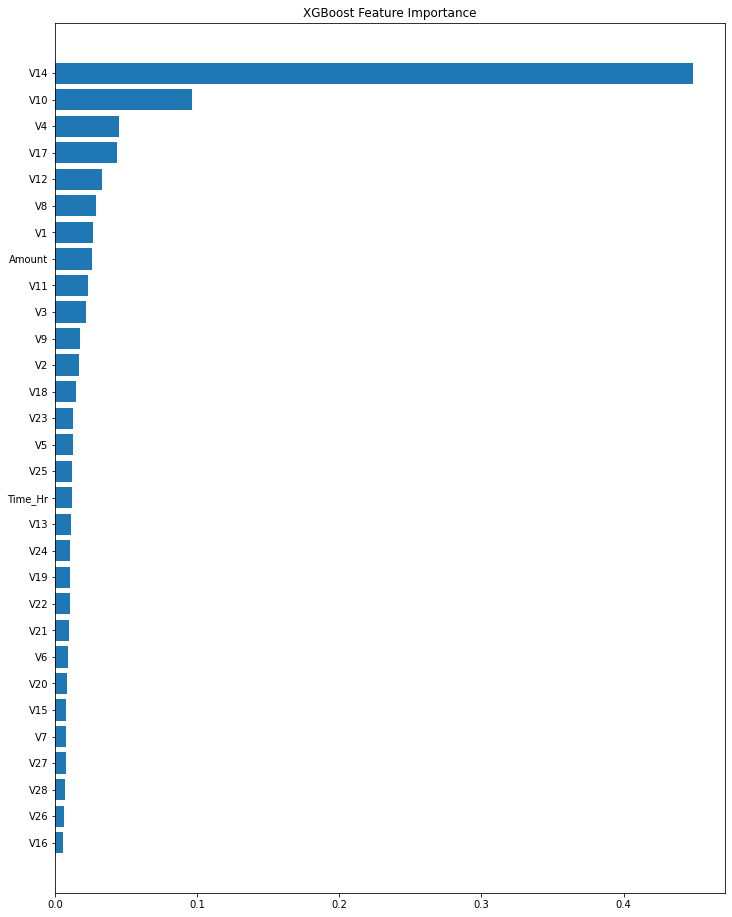

In [52]:
#Determine the variables that have high predictive power
importance = pd.DataFrame({
    'features': XX.columns,
    'importance': xgb_bestestimators.feature_importances_
})
importance.sort_values(by='importance', inplace=True)

plt.figure(figsize=(12, 16))
plt.barh(importance['features'], importance['importance'])
plt.title('XGBoost Feature Importance')
plt.show()

#####V14, V10 and V4 are the three most important features that have high predictive power in the model. 